In [1]:
import numpy as np
import sklearn
import os
from PIL import Image
import matplotlib.pyplot as plt
import hashlib
import statistics
import shutil

## data preprocessing for human face dataset (no kaggle dataset)

Info: The dataset is one big dataset with vertical and horizonal images of different sizes also.
So first we split into vertical and horizontal images (we only use vertical ones at the end).
Then we take a look at the distribution of image size of the vertical images (they have to be the same size at the end for modelling).
We throw away very small images and resize all the other ones to the lowest size remaining.
Then from these images we create 4 folders in total - 2 for training and 2 for testing.
There is one folder containing the high resolution ground truth images for each and then another with artificially downscaled images.


### Duplikate finden

In [ ]:
def find_duplicates(dir):
    # Hashes speichern
    hashes = {}

    # Durchlaufen aller Bilder im Verzeichnis
    for filename in os.listdir(dir):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Fügen Sie hier weitere Bildformate hinzu, falls nötig
            filepath = os.path.join(dir, filename)
            
            # Bild öffnen und in einen Hash umwandeln
            with Image.open(filepath) as img:
                tmp_img = img.resize((10, 10), Image.ANTIALIAS)
                hash = hashlib.sha1(tmp_img.tobytes()).hexdigest()
            
            # Falls der Hash bereits existiert, wird die Datei gelöscht
            if hash in hashes:
                os.remove(filepath)
                print(f'Gelöscht: {filepath}')
            else:
                hashes[hash] = filepath

find_duplicates('C:/Users/a829727/Downloads/archive/Humans')  # Ersetzen Sie 'IhrVerzeichnis' durch den Pfad zu Ihrem Bildverzeichnis


### horizontal / vertical split

In [ ]:
# Pfad zu Ihrem Hauptverzeichnis mit Bildern
path = "C:/Users/a829727/Downloads/archive/Humans" 

# Erstellen von Ausgabeordnern
horizontal_folder = "C:/Users/a829727/Downloads/archive/horizontal_folder"
vertical_folder = "C:/Users/a829727/Downloads/archive/vertical_folder"
if not os.path.exists(horizontal_folder):
    os.makedirs(horizontal_folder)
if not os.path.exists(vertical_folder):
    os.makedirs(vertical_folder)

# Schleife durch alle Bilder im Verzeichnis und allen Unterordnern
for root, dirs, files in os.walk(path):
    for file in files:
        # Überprüfen, ob das aktuelle Element eine Bilddatei ist und die Endung .jpg hat
        if file.endswith(".jpg") or file.endswith(".png"):
            # Öffnen des Bilds mit der Python Imaging Library (PIL)
            img = Image.open(os.path.join(root, file))
            # Überprüfen, ob das Bild breiter als hoch ist
            if img.width > img.height:
                # Bild in horizontalen Ordner kopieren
                img.convert("RGB").save(os.path.join(horizontal_folder, file))
            else:
                # Bild in vertikalen Ordner kopieren
                img.convert("RGB").save(os.path.join(vertical_folder, file))


Bilder zuschneiden [quatratisch]

In [10]:
import os
from PIL import Image

# Verzeichnispfad definieren
dir_path = 'C:/Users/a829727/Downloads/archive/Humans'
out_pfad = 'C:/Users/a829727/Downloads/archive/Humans_final'
if not os.path.exists(out_pfad):
    os.makedirs(out_pfad)

# Gehe durch alle Dateien in dem Verzeichnis
for filename in os.listdir(dir_path):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Öffne das Bild und erhalte seine Dimensionen
        img = Image.open(os.path.join(dir_path, filename)).convert("RGB")
        width, height = img.size

        # Wenn das Bild höher als breit ist, schneiden wir es zurecht
        if width < height:
            # Definiere die Koordinaten zum Zuschneiden
            left = 0
            top = 0
            right = width
            bottom = width  # Wir machen die Höhe gleich der Breite, um das Seitenverhältnis 1 zu erreichen

            # Schneide das Bild zurecht
            img_cropped = img.crop((left, top, right, bottom))

            # Speichern Sie das zugeschnittene Bild, überschreiben Sie das ursprüngliche Bild
            img_cropped.save(os.path.join(out_pfad, filename), 'JPEG')

        # Wenn das Bild breiter als hoch ist, schneiden wir es zurecht
        elif width > height:
            # Definiere die Koordinaten zum Zuschneiden
            left = (width - height) / 2
            top = 0
            right = left + height
            bottom = height

            # Schneide das Bild zurecht
            img_cropped = img.crop((left, top, right, bottom))

            # Speichern Sie das zugeschnittene Bild, überschreiben Sie das ursprüngliche Bild
            img_cropped.save(os.path.join(out_pfad, filename), 'JPEG')
        
        # Wenn die Breite gleich der Höhe ist, kopieren wir das Bild einfach
        else:
            img.save(os.path.join(out_pfad, filename), 'JPEG')

### data distribution insights

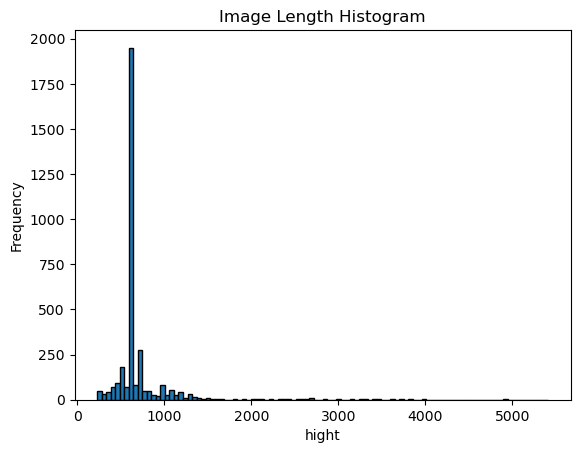

Das häufigste Seitenverhältnis ist: 600


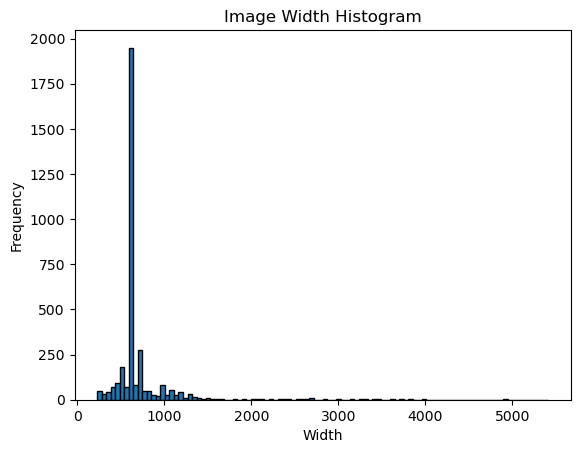

Das häufigste Seitenverhältnis ist: 600


In [12]:
#höhe und breite
def get_image_dimensions(folder_path):
    image_dimensions = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(folder_path, filename)
            with Image.open(filepath) as img:
                width, height = img.size
                image_dimensions.append((width, height))
    return image_dimensions

def create_histogram(data, title, xlabel, ylabel, direction): 
    values = [item[direction] for item in data]  # direction 0= witht und 1= hight
    plt.hist(values, bins=100, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    most_common_ratio = statistics.mode(values)
    print(f"Das häufigste Seitenverhältnis ist: {most_common_ratio}")

folder_path = "C:/Users/a829727/Downloads/archive/Humans_final"
image_dimensions = get_image_dimensions(folder_path)

create_histogram(image_dimensions, "Image Length Histogram", "hight", "Frequency",1)
create_histogram(image_dimensions, "Image Width Histogram", "Width", "Frequency",0)


Seitenverhältnisse

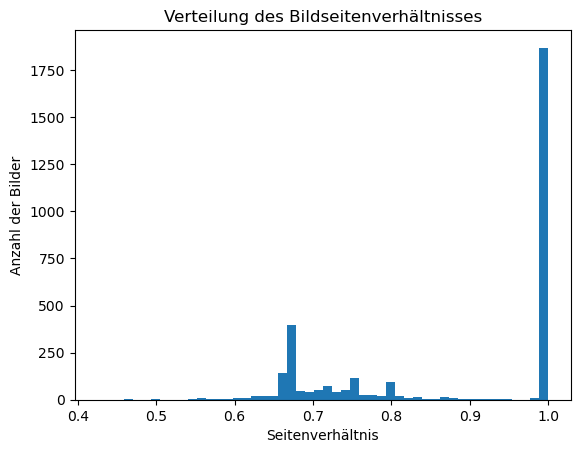

Das häufigste Seitenverhältnis ist: 1.0


In [6]:
# Verzeichnispfad definieren
dir_path = 'C:/Users/a829727/Downloads/archive/vertical_folder'

# Leere Liste für Seitenverhältnisse
aspect_ratios = []

# Gehe durch alle Dateien in dem Verzeichnis
for filename in os.listdir(dir_path):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Öffne das Bild und erhalte seine Dimensionen
        img = Image.open(os.path.join(dir_path, filename))
        width, height = img.size

        # Berechne das Seitenverhältnis und füge es der Liste hinzu
        aspect_ratios.append(width / height)

# Erstelle ein Histogramm der Seitenverhältnisse
plt.hist(aspect_ratios, bins=50)
plt.title('Verteilung des Bildseitenverhältnisses')
plt.xlabel('Seitenverhältnis')
plt.ylabel('Anzahl der Bilder')
plt.show()

# Finde und drucke das häufigste Seitenverhältnis
most_common_ratio = statistics.mode(aspect_ratios)
print(f"Das häufigste Seitenverhältnis ist: {most_common_ratio}")

throwing away small images under defined threshold

In [13]:
# Pfad zum Verzeichnis
dir_path = "C:/Users/a829727/Downloads/archive/Humans_final"

path_list=[]
# Durchlaufe alle Dateien im Verzeichnis
for filename in os.listdir(dir_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(dir_path, filename)
        # Öffne das Bild und erhalte seine Dimensionen
        with Image.open(img_path) as img:
            width, height = img.size
            # Wenn die Dimensionen kleiner sind als gefordert, lösche die Datei
            if width < 600 or height < 600:
                path_list.append(img_path)
                print(f"Datei {filename} wurde zum Abschuss freigegeben :D")

for path in path_list:
    os.remove(path)

Datei 1 (1).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1).png wurde zum Abschuss freigegeben :D
Datei 1 (100).jpg wurde zum Abschuss freigegeben :D
Datei 1 (100).png wurde zum Abschuss freigegeben :D
Datei 1 (1000).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1004).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1009).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1014).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1017).jpg wurde zum Abschuss freigegeben :D
Datei 1 (102).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1021).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1022).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1025).jpg wurde zum Abschuss freigegeben :D
Datei 1 (103).jpg wurde zum Abschuss freigegeben :D
Datei 1 (103).png wurde zum Abschuss freigegeben :D
Datei 1 (1031).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1034).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1035).jpg wurde zum Abschuss freigegeben :D
Datei 1 (1037).jpg wurde zum Abschuss freigegeben :D
Date

resizing of images to the same size (lower bound) -> needed for CNNs to work

In [ ]:
# Pfad zum Eingangs- und Ausgangsverzeichnis
input_dir_path = "./data/vertical/"
output_dir_path = "./data/data_final"

# Falls das Ausgangsverzeichnis nicht existiert, erstelle es
if not os.path.exists(output_dir_path):
    os.makedirs(output_dir_path)

# Durchlaufe alle Dateien im Verzeichnis
for filename in os.listdir(input_dir_path):
    if filename.endswith(".jpg"):
        img_path = os.path.join(input_dir_path, filename)
        # Öffne das Bild und erhalte seine Dimensionen
        with Image.open(img_path) as img:
            width, height = img.size
            # Schneide das Bild zu
            left = (width - 300)/2
            top = max(0, height - 440)  # Falls das Bild weniger als 440 hoch ist, fange oben an
            right = (width + 300)/2
            bottom = height
            img_cropped = img.crop((left, top, right, bottom))
            # Speichere das zugeschnittene Bild im Ausgangsverzeichnis
            img_cropped.save(os.path.join(output_dir_path, filename))
            print(f"Datei {filename} wurde zugeschnitten und gespeichert.")


delete grayscale images

einfache Methode mit Farbchannels

In [4]:
folder_paths = ['./data/Human/Humans_final/']

for folder_path in folder_paths:
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # add any other image types if needed
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            if len(img.getbands()) == 1:  # if the image is grayscale, it will have only one color channel
                print(f"Deleting grayscale image: {img_path}")
                img.close()  # close the image file before deleting it
                os.remove(img_path)


langsame Methode mit RGB Werten

In [3]:
def is_greyscale(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return False
    return True

# Verzeichnis mit Bildern
directory = './data/Human/Humans_final/'

# Alle Dateien in dem Verzeichnis durchlaufen
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"): # Sie können weitere Bildformate hinzufügen, falls benötigt
        image_path = os.path.join(directory, filename)
        if is_greyscale(image_path):
            print("Das Bild", filename, "ist schwarzweiß.")
            os.remove(image_path)

Das Bild 1 (105).jpg ist schwarzweiß.
Das Bild 1 (118).jpg ist schwarzweiß.
Das Bild 1 (1522).jpg ist schwarzweiß.
Das Bild 1 (721).jpg ist schwarzweiß.


splitting into train / test and downscaling

In [5]:
def downsample_image(image_path, output_size):
    # Open the image
    image = Image.open(image_path)

    # Perform downsampling using bicubic interpolation
    downscaled_image = image.resize(output_size, resample=Image.BICUBIC)

    return downscaled_image

# Folder path containing the images
folder_path = "C:/Users/a829727/Downloads/archive/Humans_final_600"

# Defining folder for downscaled images serving for input for modelling (&upscaling)
output_folder_path = "C:/Users/a829727/Downloads/archive/Humans_final_200"

test_low_res_folder = "C:/Users/a829727/Downloads/archive/Humans_final_200_test"
test_original = "C:/Users/a829727/Downloads/archive/Humans_final_600_test"

if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
if not os.path.exists(test_low_res_folder):
    os.makedirs(test_low_res_folder)
if not os.path.exists(test_original):
    os.makedirs(test_original)


# Output size for downsampling (by a factor of 3)
output_size = (200, 200)

number_images = len(os.listdir(folder_path))

# Iterate over the files in the folder
for number, filename in enumerate(os.listdir(folder_path)):

    # Check if the file is an image (optional)
    if number<=0.8*number_images:
      # Construct the full path to the image file
      image_path = os.path.join(folder_path, filename)

      # Apply downsampling to the image
      downsampled_image = downsample_image(image_path, output_size)

      # Save the downscaled image
      output_filename = f"downsampled_{filename}"
      output_path = os.path.join(output_folder_path, output_filename)
      downsampled_image.save(output_path)

    else:
      # Construct the full path to the image file
      image_path = os.path.join(folder_path, filename)

      image = Image.open(image_path)
      image.save(os.path.join(test_original, filename))


      # Apply downsampling to the image
      downsampled_image = downsample_image(image_path, output_size)

      # Save the downscaled image
      output_filename = f"downsampled_{filename}"
      output_path = os.path.join(test_low_res_folder, output_filename)
      downsampled_image.save(output_path)

      os.remove(os.path.join(folder_path, filename))


## kaggle dataset processing

Info: Kaggle datasets we use are split into train and test data by default (validation split is done via model training later and not saved to disk into seperate folders), same size and all RGB. So preprocessing is just creating the low resolution data for model input.

creating low resolution input dataset for training

In [3]:
def downsample_image(image_path, output_size):
    # Open the image
    image = Image.open(image_path)

    # Perform downsampling using bicubic interpolation
    downscaled_image = image.resize(output_size, resample=Image.BICUBIC)

    return downscaled_image

# Folder path containing the images
folder_path = "C:/Users/a829727/Downloads/archive/Humans_final"

# Defining folder for downscaled images serving for input for modelling (&upscaling)
output_folder_path = "C:/Users/a829727/Downloads/archive/Humans_final_200"
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)


# Output size for downsampling (by a factor of 3)
output_size = (200, 200)

# Iterate over the files in the folder
for number, filename in enumerate(os.listdir(folder_path)):

  # Construct the full path to the image file
  image_path = os.path.join(folder_path, filename)

  # Apply downsampling to the image
  downsampled_image = downsample_image(image_path, output_size)

  # Save the downscaled image
  output_filename = f"downsampled_{filename}"
  output_path = os.path.join(output_folder_path, output_filename)
  downsampled_image.save(output_path)


creating low resolution input dataset for training

In [ ]:
def downsample_image(image_path, output_size):
    # Open the image
    image = Image.open(image_path)

    # Perform downsampling using bicubic interpolation
    downscaled_image = image.resize(output_size, resample=Image.BICUBIC)

    return downscaled_image

# Folder path containing the images
folder_path = "/kaggle/input/animal-faces/afhq/train/dog"

# Defining folder for downscaled images serving for input for modelling (&upscaling)
output_folder_path = "/kaggle/working/dog_low_res"
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)


# Output size for downsampling (by a factor of 3)
output_size = (128, 128)

# Iterate over the files in the folder
for number, filename in enumerate(os.listdir(folder_path)):

  # Construct the full path to the image file
  image_path = os.path.join(folder_path, filename)

  # Apply downsampling to the image
  downsampled_image = downsample_image(image_path, output_size)

  # Save the downscaled image
  output_filename = f"downsampled_{filename}"
  output_path = os.path.join(output_folder_path, output_filename)
  downsampled_image.save(output_path)
